Import Libraries

In [1]:
# imp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import time

# **Load the Dataset**

Here I loaded the stock data into a DataFrame and changed the Date column to a date format so we can use it for time-based stuff. Then I set the Date column as the index so it’s easier to work with. I also used *asfreq('b')* to make sure the data only includes business days (Monday to Friday) because stock markets are closed on weekends.

In [2]:

#dataset
file_path = 'GOOGL_2006-01-01_to_2018-01-01.csv'
stock_prices = pd.read_csv(file_path)



#convert the Date column to datetime format
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])

#set Date column as the index
stock_prices.set_index('Date', inplace=True)





# dropping Name column
if 'Name' in stock_prices.columns:
    stock_prices.drop('Name', axis=1, inplace=True)



#set the frequency to business days(monday to Friday)
stock_prices = stock_prices.asfreq('b')


# **Check Missing Values**
I checked how many missing (NaN) values there are in the Open column. I also separated them into values on business days and weekends, just to understand where the gaps are. Yesterday, Workshop 5, Duma was taking about this.

In [3]:


#identify weekend dates (saturday and sunday)
weekends = stock_prices.index.dayofweek >= 5

#NaN values specifically on weekends
weekend_nan = stock_prices.loc[weekends, 'Open'].isna().sum()
print(f"Total NaN values in 'Open' column on weekends: {weekend_nan}")

#NaN values on business days (excluding weekends)
business_day_nan = stock_prices.loc[~weekends, 'Open'].isna().sum()
print(f"Total NaN values in 'Open' column on business days: {business_day_nan}")

Total NaN values in 'Open' column on weekends: 0
Total NaN values in 'Open' column on business days: 110


Here, I filled the missing values using two methods: forward fill (ffill) and backward fill (bfill). Forward fill fills gaps with the last known value, and backward fill fills gaps with the next known value.

In [4]:



#exclude Weekend Dates
#stock_prices = stock_prices[stock_prices.index.dayofweek < 5]


#filling missing values using forward and backward fill methods
stock_prices = stock_prices.fillna(method='bfill').fillna(method='ffill')






<ipython-input-4-66146d9bd38d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_prices = stock_prices.fillna(method='bfill').fillna(method='ffill')


jus to make sure

In [5]:
# NaN values specifically on weekends
weekend_nan = stock_prices.loc[weekends, 'Open'].isna().sum()
print(f"Total NaN values in 'Open' column on weekends: {weekend_nan}")

# NaN values on business days (excluding weekends)
business_day_nan = stock_prices.loc[~weekends, 'Open'].isna().sum()
print(f"Total NaN values in 'Open' column on business days: {business_day_nan}")


Total NaN values in 'Open' column on weekends: 0
Total NaN values in 'Open' column on business days: 0


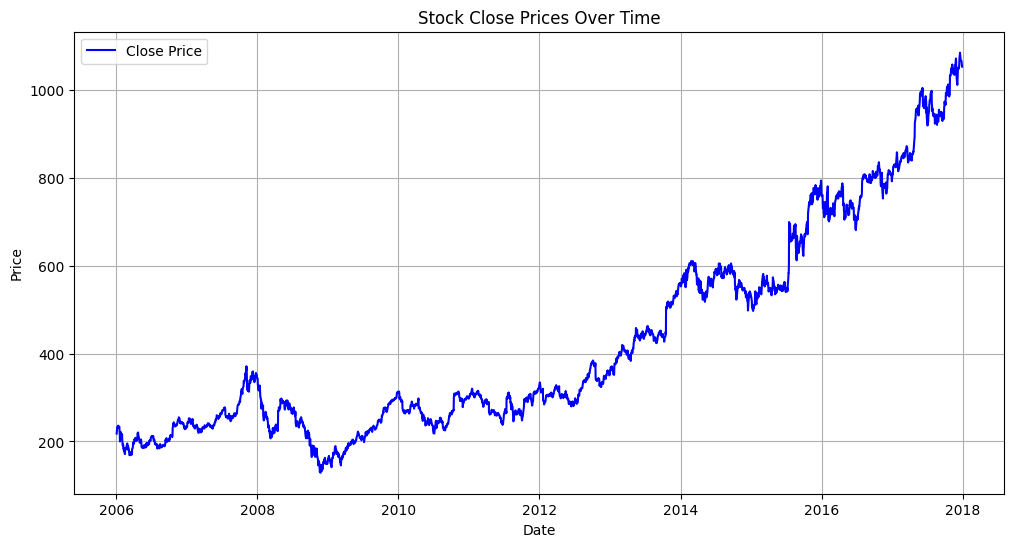

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(stock_prices['Close'], label='Close Price', color='blue')
plt.title("Stock Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


Normalize Data

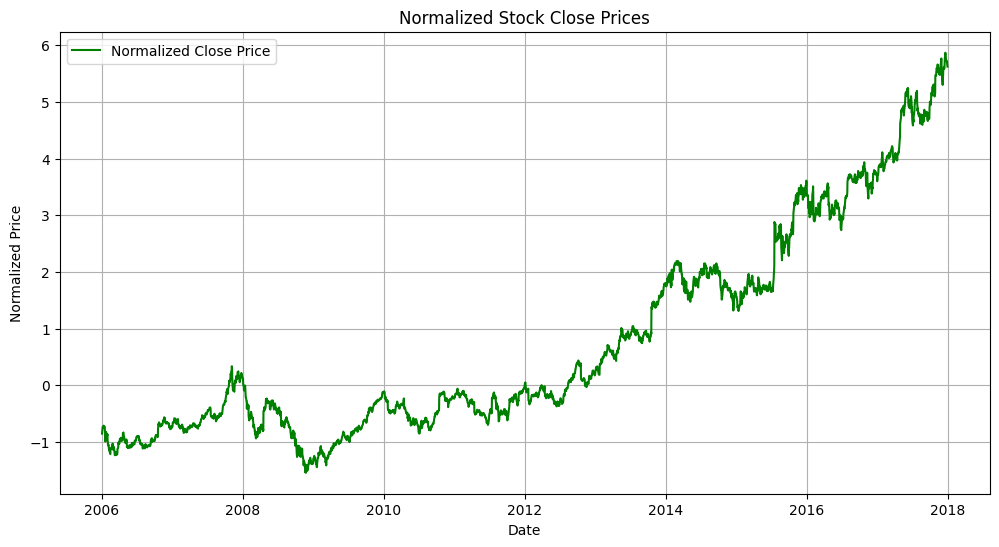

In [7]:
#normalize the data using standardScaler
train_ratio = 0.8
val_ratio = 0.1
train_end_idx = int(stock_prices.shape[0] * train_ratio)
val_end_idx = int(stock_prices.shape[0] * (train_ratio + val_ratio))




#scaling training data and applying the same transformation to validation and test data
scaler = StandardScaler()
stock_prices.iloc[:train_end_idx] = scaler.fit_transform(stock_prices.iloc[:train_end_idx])
stock_prices.iloc[train_end_idx:] = scaler.transform(stock_prices.iloc[train_end_idx:])




# plotting the normalized Close prices
plt.figure(figsize=(12, 6))
plt.plot(stock_prices['Close'], label='Normalized Close Price', color='green')
plt.title("Normalized Stock Close Prices")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid()
plt.show()


# **Create Lagged Variables**

In this cell, I created "lagged variables" from the dataset. Basically, I made a new version of the data where each row includes information from previous time steps (like yesterday, the day before, etc.) along with the current value. This helps the model look at past trends to predict future values.

For example, if we’re working with 50 lagged steps, the row for today will include the stock prices for the past 50 days. This makes the data more useful for models like LSTMs that need sequential information to make predictions. I also dropped some columns that I didn’t need to keep things simple. This step is super important because time-series models need to see past data to predict the future. Without this, the model wouldn’t know the historical trends!

In [8]:

#to convert time series data into supervised learning format
def create_lagged_data(data, num_lags=1, forecast=1, drop_na=True):
    n_features = data.shape[1]
    columns, names = [], []



    #creating lagged variables
    for lag in range(num_lags, 0, -1):
        columns.append(data.shift(lag))
        names += [f'{data.columns[col]}(t-{lag})' for col in range(n_features)]




    #creating variables for the current and future time steps
    for step in range(0, forecast):
        columns.append(data.shift(-step))
        names += [f'{data.columns[col]}(t)' for col in range(n_features)]



    #comcbine all columns and drop rows with NaN values
    #removes rows that contain NaN values after creating lagged variables.
    #when creating lagged columns, the first few rows will have missing values because there isn’t enough past data to populate them.
    result = pd.concat(columns, axis=1)
    result.columns = names
    if drop_na:
        result.dropna(inplace=True)
    return result



#lagged variables
num_lag_steps = 50
processed_data = create_lagged_data(stock_prices, num_lags=num_lag_steps, forecast=1)

# drop unwanted columns for simplicity
processed_data.drop(['High(t)', 'Low(t)', 'Volume(t)', f'Open(t-{num_lag_steps})'], axis=1, inplace=True)

print(processed_data.head())


            High(t-50)  Low(t-50)  Close(t-50)  Volume(t-50)  Open(t-49)  \
Date                                                                       
2006-03-14   -0.873583  -0.899477    -0.854132      2.874576   -0.821259   
2006-03-15   -0.822255  -0.815580    -0.815302      3.548553   -0.813123   
2006-03-16   -0.812220  -0.808725    -0.791972      2.148403   -0.770969   
2006-03-17   -0.738971  -0.762920    -0.736091      4.320195   -0.733929   
2006-03-20   -0.727779  -0.732929    -0.731286      2.767732   -0.741678   

            High(t-49)  Low(t-49)  Close(t-49)  Volume(t-49)  Open(t-48)  ...  \
Date                                                                      ...   
2006-03-14   -0.822255  -0.815580    -0.815302      3.548553   -0.813123  ...   
2006-03-15   -0.812220  -0.808725    -0.791972      2.148403   -0.770969  ...   
2006-03-16   -0.738971  -0.762920    -0.736091      4.320195   -0.733929  ...   
2006-03-17   -0.727779  -0.732929    -0.731286      2.767732  

Split Data into Train, Validation, and Test Sets

In [9]:


#training, validation, and test sets
train_features = processed_data.iloc[:train_end_idx, :-1].values
train_labels = processed_data.iloc[:train_end_idx, -1].values
val_features = processed_data.iloc[train_end_idx:val_end_idx, :-1].values
val_labels = processed_data.iloc[train_end_idx:val_end_idx, -1].values
test_features = processed_data.iloc[val_end_idx:, :-1].values
test_labels = processed_data.iloc[val_end_idx:, -1].values

#shapes of the splits
print(f"Shapes - Train: {train_features.shape}, Validation: {val_features.shape}, Test: {test_features.shape}")

Shapes - Train: (2503, 250), Validation: (313, 250), Test: (263, 250)


# **Reshape Data for LSTM**

reshaped the data into a 3D format—(samples, time steps, features)—which is required for LSTM models to work. Each row now represents a sequence of past days (lagged variables) and features like Open and Close prices

In [10]:

# reshape data into 3D format required by LSTM (samples, time_steps, features)
num_features = stock_prices.shape[1]
train_features = train_features.reshape((train_features.shape[0], num_lag_steps, num_features))
val_features = val_features.reshape((val_features.shape[0], num_lag_steps, num_features))
test_features = test_features.reshape((test_features.shape[0], num_lag_steps, num_features))


Define and Train the LSTM Model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
79/79 - 6s - 71ms/step - loss: 0.0493 - val_loss: 0.0166
Epoch 2/100
79/79 - 1s - 9ms/step - loss: 0.0110 - val_loss: 0.0162
Epoch 3/100
79/79 - 1s - 16ms/step - loss: 0.0079 - val_loss: 0.0120
Epoch 4/100
79/79 - 1s - 9ms/step - loss: 0.0063 - val_loss: 0.0112
Epoch 5/100
79/79 - 1s - 9ms/step - loss: 0.0057 - val_loss: 0.0105
Epoch 6/100
79/79 - 1s - 9ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 7/100
79/79 - 1s - 9ms/step - loss: 0.0046 - val_loss: 0.0091
Epoch 8/100
79/79 - 1s - 16ms/step - loss: 0.0042 - val_loss: 0.0085
Epoch 9/100
79/79 - 1s - 16ms/step - loss: 0.0039 - val_loss: 0.0081
Epoch 10/100
79/79 - 1s - 9ms/step - loss: 0.0036 - val_loss: 0.0089
Epoch 11/100
79/79 - 1s - 10ms/step - loss: 0.0035 - val_loss: 0.0144
Epoch 12/100
79/79 - 1s - 16ms/step - loss: 0.0043 - val_loss: 0.0075
Epoch 13/100
79/79 - 1s - 9ms/step - loss: 0.0051 - val_loss: 0.0182
Epoch 14/100
79/79 - 1s - 16ms/step - loss: 0.0056 - val_loss: 0.0069
Epoch 15/100
79/79 - 1s - 16ms/step 

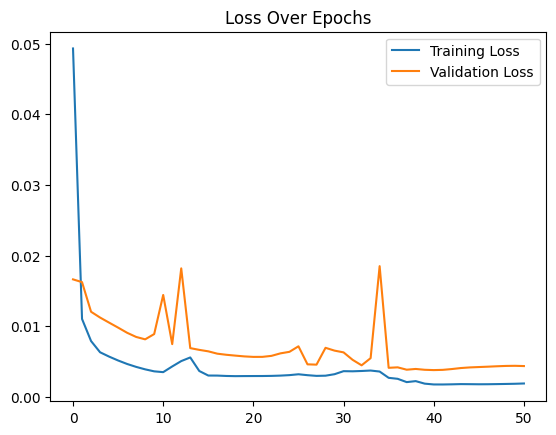

In [11]:

# define LSTM model architecture
hidden_units = 500
#hidden_units = 20
batch_size = 32
n_epochs = 100
#n_epochs = 50
learning_rate = 0.0005
#learning_rate = 0.0001



#optimizer and Early Stopping
optimizer = Adam(learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#build the model
model = Sequential()
model.add(LSTM(hidden_units, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dense(1))  # Output layer
model.compile(loss='mse', optimizer=optimizer)



#train the model
start_time = time.time()
history = model.fit(
    train_features, train_labels, epochs=n_epochs, batch_size=batch_size,
    validation_data=(val_features, val_labels), verbose=2, shuffle=False,
    callbacks=[early_stopping]
)
end_time = time.time()
print("Total training time:", end_time - start_time)



#training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

Make Predictions and Evaluate

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


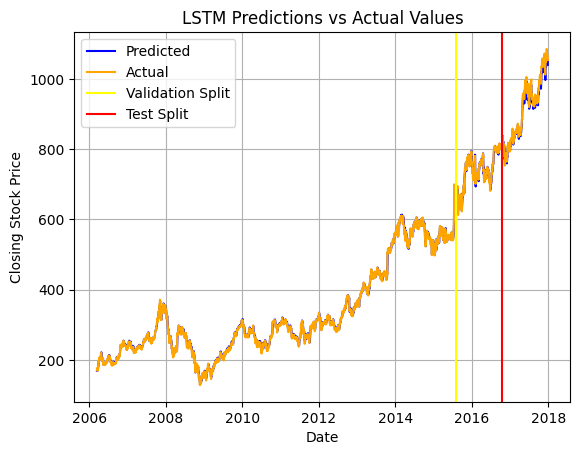

Train RMSE: 5.448882934255707, Validation RMSE: 7.9335959083600835, Test RMSE: 12.560408963504495


In [12]:

# predictions on train, validation, and test sets
pred_train = model.predict(train_features).flatten()
pred_val = model.predict(val_features).flatten()
pred_test = model.predict(test_features).flatten()

# rescale predictions and real values back to original scale
mean_close = scaler.mean_[scaler.feature_names_in_ == 'Close'][0]
std_close = np.sqrt(scaler.var_[scaler.feature_names_in_ == 'Close'][0])

pred_all = np.concatenate([pred_train, pred_val, pred_test]) * std_close + mean_close
actual_all = np.concatenate([train_labels, val_labels, test_labels]) * std_close + mean_close

# plot predictions vs actual values
plt.plot(stock_prices.iloc[num_lag_steps:].index, pred_all, label='Predicted', color='blue')
plt.plot(stock_prices.iloc[num_lag_steps:].index, actual_all, label='Actual', color='orange')
plt.axvline(x=stock_prices.iloc[train_end_idx].name, color='yellow', label='Validation Split')
plt.axvline(x=stock_prices.iloc[val_end_idx].name, color='red', label='Test Split')
plt.legend()
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel("Date")
plt.ylabel("Closing Stock Price")
plt.grid(True)
plt.show()

#RMSE and MAE
train_rmse = np.sqrt(mean_squared_error(actual_all[:train_end_idx], pred_all[:train_end_idx]))
val_rmse = np.sqrt(mean_squared_error(actual_all[train_end_idx:val_end_idx], pred_all[train_end_idx:val_end_idx]))
test_rmse = np.sqrt(mean_squared_error(actual_all[val_end_idx:], pred_all[val_end_idx:]))

print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}, Test RMSE: {test_rmse}")


predictions vs actual values for the test set

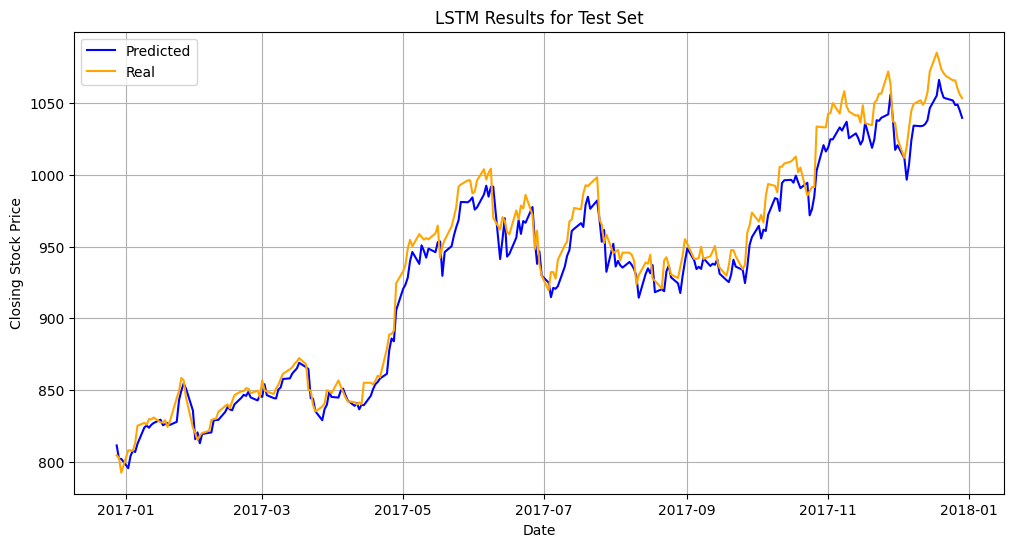

In [13]:
#predictions vs actual values for the test set
plt.figure(figsize=(12, 6))
plt.plot(stock_prices.iloc[num_lag_steps + val_end_idx:].index, pred_all[val_end_idx:], label='Predicted', color='blue')
plt.plot(stock_prices.iloc[num_lag_steps + val_end_idx:].index, actual_all[val_end_idx:], label='Real', color='orange')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock Price")
plt.title("LSTM Results for Test Set")
plt.grid(True)
plt.show()
